In [84]:
import gensim
import re
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import string
import nltk
from nltk.corpus import stopwords
from sklearn import metrics
import statistics
import matplotlib.pyplot as plt

In [63]:
#load the model
model = gensim.models.Word2Vec.load('D:/download2/full_grams_sg_300_twitter/full_grams_sg_300_twitter.mdl')

In [64]:
#set number of features(length of vector)
num_features = 300

In [65]:
#load the dataset
df = pd.read_csv("finalDataset.csv")
#drop NaN rows 
df = df.dropna()

df.shape

(12400, 6)

In [66]:
df.head()

,tweet,label1,label2,label3,finalLabel,sector
0,@tfrabiah دكتور اعاني من مشكله والدتي كبيره في...,-1,-1,-1,-1,private
1,@SaudiMOH مستشفى عبيد التخصصي لا يجري اي تدابي...,-1,-1,-1,-1,private
2,@Ahmed_S_Alrajhi يابو سليمان ليتك تجي تشوف الت...,-1,-1,-1,-1,private
3,في مستشفى الموسى التخصصي @almoosahospital ينته...,-1,-1,-1,-1,private
4,@SaAskExp نصيحتي لك اهرب مستشفى متهالك تدخل مت...,-1,-1,-1,-1,private


In [67]:
X = df['tweet']
y = df['finalLabel']

# Preprocessing

In [68]:
def replace_emoji(tweet):
    result = ' '
    for char in tweet:
        result += emoji_dict.get(char, char)
    return result

In [69]:
emj_df = pd.read_csv("emoji.csv")
emj = emj_df['Emoji']
sent = emj_df['sentiment']

emoji_dict = {emj[i]: sent[i] for i in range(len(emj))}

In [70]:
#function to clean and normalize each tweet
def preprocess(tweet): 
    
    #Replace emoji with their semantics
    tweet =  replace_emoji(tweet)
    
    #Remove http links and mention tags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Remove punctuations
    eng_punct = string.punctuation
    arabic_punct = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    punct_list = eng_punct + arabic_punct
    tweet = re.sub('[%s]' % re.escape(punct_list), ' ', tweet)
    
    #Remove digits
    tweet = re.sub(r'[0-9]+', '', tweet)    
    
    #Remove English words
    tweet = re.sub(r'\s*[A-Za-z]+\b', '' , tweet)
    tweet = tweet.rstrip()
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    tweet = re.sub(p_tashkeel,"", tweet)
    
    
    #Remove elongation (repeated letters)
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
 
    tweet = tweet.replace('وو', 'و')
    tweet = tweet.replace('يي', 'ي')
    tweet = tweet.replace('اا', 'ا')
    
    #Normalize letters
    tweet = re.sub("[إأآا]", "ا", tweet)
    tweet = re.sub("ى", "ي", tweet)
    tweet = re.sub("ة", "ه", tweet) 
    #tweet = re.sub("گ", "ك", tweet)
    
    #Tokenize tweets and remove stop words
    stopword_list = stopwords.words('arabic')
    tokens = nltk.word_tokenize(tweet)
    clean_tokens = [w for w in tokens if w not in stopword_list]
    tweet = clean_tokens
    
    return tweet

In [72]:
X = [preprocess(tweet) for tweet in X]

# Word Embedding

In [73]:
not_found = 0

In [74]:
def word_vector(tokens, size, not_found):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            not_found = not_found +1
    if count != 0:
        vec /= count
    return vec, not_found

In [75]:
trainvecs = np.zeros((len(X), 300)) 
for i in range(len(X)):
    if i%1000 == 0:
        print("Review %d of %d"%(i,len(X)))
    trainvecs[i,:], not_found = word_vector(X[i], 300, not_found)
train_df = pd.DataFrame(trainvecs)
train_df.shape

Review 0 of 12400
Review 1000 of 12400
Review 2000 of 12400
Review 3000 of 12400
Review 4000 of 12400
Review 5000 of 12400
Review 6000 of 12400
Review 7000 of 12400
Review 8000 of 12400
Review 9000 of 12400
Review 10000 of 12400
Review 11000 of 12400
Review 12000 of 12400


(12400, 300)

In [76]:
not_found 

7365

In [77]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.035000,-0.063119,0.041225,-0.007127,-0.093626,0.013260,0.024302,0.131483,0.195272,0.072334,...,-0.120799,0.161850,-0.074506,0.137433,-0.202058,-0.129927,-0.074563,-0.104690,-0.242893,0.029386
1,-0.002358,-0.049349,0.127819,0.033890,-0.109807,0.074026,-0.008648,0.256219,0.033318,-0.082484,...,-0.103116,0.170789,-0.102738,0.008102,-0.249915,-0.182160,-0.124055,0.002594,-0.182736,0.085631
2,-0.006748,-0.106278,0.171343,0.054713,-0.027100,0.001456,-0.066215,0.209260,0.071730,0.016996,...,-0.095918,0.258481,-0.062382,0.141522,-0.262340,-0.073579,-0.037189,-0.052655,-0.177113,0.167130
3,-0.051608,-0.066554,0.007458,-0.020472,-0.116221,-0.029016,-0.006034,0.016475,0.086276,0.030419,...,-0.172989,0.110122,0.011963,0.091052,-0.330741,-0.171295,0.013318,-0.026222,-0.130250,0.085288
4,0.081102,-0.132850,0.077125,0.025737,0.002054,0.021966,-0.002050,0.105279,0.108427,0.051023,...,-0.213712,0.196447,-0.119228,0.010986,-0.225218,-0.151926,-0.063673,-0.006175,-0.131117,0.066686


In [54]:
#Create a svm Classifier
from sklearn.model_selection import cross_validate
clf = svm.SVC(kernel='rbf') # Gaussian Kernel


In [55]:
scoresGauss = cross_validate(clf, trainvecs, y, cv=10, scoring=('accuracy','f1_micro', 'f1_macro'),return_train_score=True)

In [56]:
acc = scoresGauss['test_accuracy']
print(acc)
print("mean: "+str(np.average(acc)))
print("min: "+str(min(acc)))
print("max: "+str(max(acc)))
print("std: "+str(statistics.stdev(acc)))

[0.95967742 0.96612903 0.96290323 0.9516129  0.95403226 0.95322581
 0.95725806 0.97016129 0.97983871 0.89112903]
mean: 0.9545967741935485
min: 0.8911290322580645
max: 0.9798387096774194
std: 0.023929412372767432


In [57]:
micro = scoresGauss['test_f1_micro']
print(micro)
print("mean: "+str(np.average(micro)))
print("min: "+str(min(micro)))
print("max: "+str(max(micro)))
print("std: "+str(statistics.stdev(micro)))

[0.95967742 0.96612903 0.96290323 0.9516129  0.95403226 0.95322581
 0.95725806 0.97016129 0.97983871 0.89112903]
mean: 0.9545967741935485
min: 0.8911290322580645
max: 0.9798387096774194
std: 0.023929412372767436


In [58]:
macro = scoresGauss['test_f1_macro']
print(macro)
print("mean: "+str(np.average(macro)))
print("min: "+str(min(macro)))
print("max: "+str(max(macro)))
print("std: "+str(statistics.stdev(macro)))

[0.95601077 0.96323322 0.95984897 0.94772917 0.9506416  0.95039945
 0.95315455 0.96787203 0.9782717  0.87783866]
mean: 0.9505000119556118
min: 0.8778386638439662
max: 0.9782717032391284
std: 0.027177166719923943


In [78]:
from sklearn.model_selection import KFold
 
clf2 = svm.SVC(kernel='linear') # Linear Kernel

cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_validate(clf2, trainvecs, y, scoring=('accuracy','f1_micro', 'f1_macro'),return_train_score=True, cv=cv, n_jobs=-1)

In [80]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# we get same results each run
y_pred = cross_val_predict(clf2, trainvecs, y, cv=cv)

In [79]:
acc = scores['test_accuracy']
print(acc)
print("mean: "+str(np.average(acc)))
print("min: "+str(min(acc)))
print("max: "+str(max(acc)))
print("std: "+str(statistics.stdev(acc)))

[0.96693548 0.96612903 0.96935484 0.96854839 0.96290323 0.96209677
 0.95806452 0.95887097 0.95322581 0.96370968]
mean: 0.9629838709677419
min: 0.9532258064516129
max: 0.9693548387096774
std: 0.005106819419028248


In [61]:
micro = scores['test_f1_micro']
print(micro)
print("mean: "+str(np.average(micro)))
print("min: "+str(min(micro)))
print("max: "+str(max(micro)))
print("std: "+str(statistics.stdev(micro)))

[0.95645161 0.95967742 0.96209677 0.96693548 0.95483871 0.95967742
 0.95322581 0.95080645 0.9483871  0.95887097]
mean: 0.9570967741935485
min: 0.9483870967741934
max: 0.9669354838709677
std: 0.005519596889337924


In [62]:
macro = scores['test_f1_macro']
print(macro)
print("mean: "+str(np.average(macro)))
print("min: "+str(min(macro)))
print("max: "+str(max(macro)))
print("std: "+str(statistics.stdev(macro)))

[0.95272842 0.95627287 0.95899583 0.96394712 0.95102561 0.95623002
 0.94993303 0.94776961 0.94504018 0.95515374]
mean: 0.953709644235665
min: 0.9450401810571454
max: 0.9639471233931685
std: 0.005584013417522471


In [101]:
font = {'size'   : 20}
plt.rc('font', **font)

In [104]:
import seaborn as sns  
from sklearn.metrics import confusion_matrix  
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array):  
  
    matrix = confusion_matrix(actual_classes, predicted_classes)  
      
    plt.figure(figsize=(12.8,6))  
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g")  
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix SVM')  
  
    plt.show()

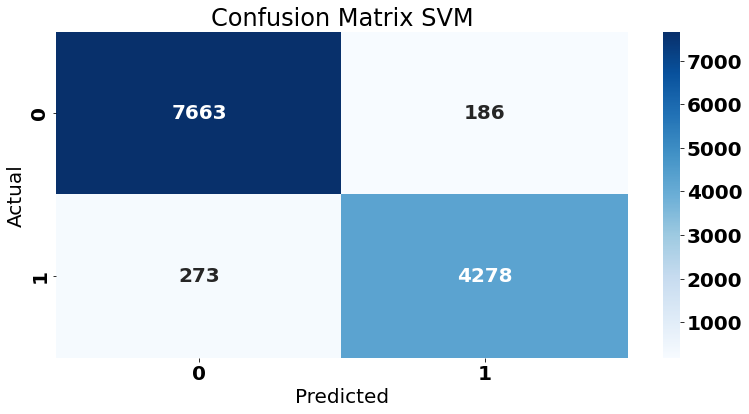

In [105]:
plot_confusion_matrix(y, y_pred)